### Step 1:  Load the data & create the necessary features

In [2]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math

In [3]:
## import data
data=pd.read_csv('data/Binance_BTCUSDT_1h.csv')

In [4]:
# Calculate technical indicators
def get_technical_indicators(data):
    # Create 7 and 21 days Moving Average
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean()
    data['MA21'] = data.iloc[:,4].rolling(window=21).mean()

    # Create MACD
    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA21'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA21'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data
T_df = get_technical_indicators(df)


### Step 2: Process the data

In [8]:
import statsmodels.api as sm
from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

In [9]:
#Load Data
dataset = pd.read_csv('Final_data.csv', parse_dates=['Date'])

In [11]:
# Replace 0 by NA
dataset.replace(0, np.nan, inplace=True)
dataset.to_csv("dataset.csv", index=False)

In [12]:
# Check NA and fill them
dataset.isnull().sum()
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill(), dataset.iloc[:, 1:].bfill()]).groupby(level=0).mean()
print(dataset.columns)
# Confirm no NA is left
dataset.isnull().sum().sum()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ETHUSD',
       'XRPUSD', 'LTCUSD', 'S&P 500', 'DJ', 'MA7', 'MA21', 'MACD', '20SD',
       'upper_band', 'lower_band', 'EMA', 'logmomentum'],
      dtype='object')


0

In [13]:
# Set indexes to datetime for eaiser use
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [14]:
# Get features and target (define X and y)
X_value = pd.DataFrame(dataset.iloc[:, :])
y_value = pd.DataFrame(dataset.iloc[:, 3])

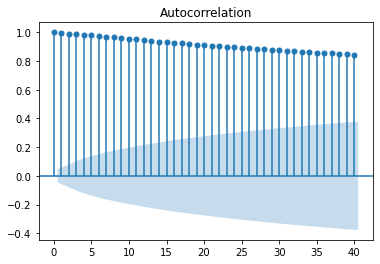

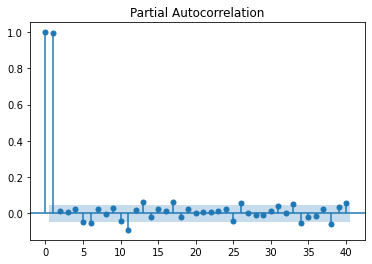

In [15]:
# Autocorrelation & partial correlation Check (commonly used in timeseries problems)
sm.graphics.tsa.plot_acf(y_value.squeeze(), lags=40)
plt.show()
sm.graphics.tsa.plot_pacf(y_value.squeeze(), lags=40)
plt.show()


In [16]:
# Normalize the data using MinMaxScaler (because we have heterogenous features)
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaler.fit(X_value)
y_scaler.fit(y_value)

MinMaxScaler(feature_range=(-1, 1))

In [17]:
#After scaling the data, we save the scaler for later use
X_scale_dataset = X_scaler.fit_transform(X_value)
y_scale_dataset = y_scaler.fit_transform(y_value)
dump(X_scaler, open('X_scaler.pkl', 'wb'))
dump(y_scaler, open('y_scaler.pkl', 'wb'))

In [18]:
# Define the parameters used for reshaping the data: we use the last 30 days of data to predict 3 days price
n_steps_in = 3
n_features = X_value.shape[1]
n_steps_out = 1
print('number of features used is:', n_features)

number of features used is: 19


In [19]:
# Build X and y datasets
def get_X_y(X_data, y_data):
    X = list()
    y = list()
    yc = list()

    length = len(X_data)
    for i in range(0, length, 1):
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        yc_value = y_data[i: i + n_steps_in][:, :]
        if len(X_value) == 3 and len(y_value) == 1:
            X.append(X_value)
            y.append(y_value)
            yc.append(yc_value)

    return np.array(X), np.array(y), np.array(yc)

In [20]:
# get the train test predict index
def predict_index(dataset, X_train, n_steps_in, n_steps_out):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in:, :].index

    return train_predict_index, test_predict_index

In [21]:
# Split train/test dataset (70% train, 30% test)
def split_train_test(data):
    train_size = round(len(X) * 0.7)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [22]:
# Get data and check shape
X, y, yc = get_X_y(X_scale_dataset, y_scale_dataset)
X_train, X_test, = split_train_test(X)
y_train, y_test, = split_train_test(y)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, n_steps_in, n_steps_out)

In [23]:
print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('y_c_train shape: ', yc_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('y_c_test shape: ', yc_test.shape)
print('index_train shape:', index_train.shape)
print('index_test shape:', index_test.shape)

X shape:  (1796, 3, 19)
y shape:  (1796, 1)
X_train shape:  (1257, 3, 19)
y_train shape:  (1257, 1)
y_c_train shape:  (1257, 3, 1)
X_test shape:  (539, 3, 19)
y_test shape:  (539, 1)
y_c_test shape:  (539, 3, 1)
index_train shape: (1257,)
index_test shape: (539,)


### Step 3: Building the Model

In [24]:
import time
import os
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from pickle import load
from sklearn.metrics import mean_squared_error

In [25]:
#The generator is a GRU model
def make_generator_model(input_dim, output_dim, feature_size) -> tf.keras.models.Model:

    model = Sequential()
    model.add(GRU(units=1024, return_sequences = True, input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.2))
    model.add(GRU(units=512, return_sequences = True, recurrent_dropout=0.2)) # 256, return_sequences = True
    model.add(GRU(units=256, recurrent_dropout=0.2)) #, recurrent_dropout=0.1
    # , recurrent_dropout = 0.2
    model.add(Dense(128))
    # model.add(Dense(128))
    model.add(Dense(64))
    #model.add(Dense(16))
    model.add(Dense(units=output_dim))
    return model

In [26]:
#The discriminator is a CNN model
def make_discriminator_model():

    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [27]:
model = make_discriminator_model()
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2, 32)             128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             10304     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 128)            41088     
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 220)               28160     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 220)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 220)               4

In [28]:
# Defining the GAN Model as an object
class GAN:
    def __init__(self, generator, discriminator, opt):
        self.opt = opt
        self.lr = opt["lr"]
        self.generator = generator
        self.discriminator = discriminator
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.batch_size = self.opt['bs']
        self.checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                              discriminator_optimizer=self.discriminator_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)
    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    @tf.autograph.experimental.do_not_convert
    def train_step(self, real_x, real_y, yc):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_data = self.generator(real_x, training=True)
            generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
            d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
            real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            d_real_input = tf.concat([real_y_reshape, yc], axis=1)

            real_output = self.discriminator(d_real_input, training=True)
            fake_output = self.discriminator(d_fake_input, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': gen_loss}

    def train(self, real_x, real_y, yc, opt):
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []

        epochs = opt["epoch"]
        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(real_x, real_y, yc)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price.numpy())
            Real_price.append(real_price.numpy())

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                tf.keras.models.save_model(generator, 'model_%d.h5' % epoch)
                self.checkpoint.save(file_prefix=self.checkpoint_prefix + f'-{epoch}')
                print('epoch', epoch + 1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())
            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)
            
        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(
            Real_price)


epoch 15 d_loss 1.4452844 g_loss 0.47804162
epoch 30 d_loss 1.4419532 g_loss 0.48397323
epoch 45 d_loss 1.4343473 g_loss 0.4942921
epoch 60 d_loss 1.422845 g_loss 0.5190992
epoch 75 d_loss 1.403895 g_loss 0.5695061
epoch 90 d_loss 1.3909249 g_loss 0.62868637
epoch 105 d_loss 1.3872018 g_loss 0.66006184
epoch 120 d_loss 1.3869894 g_loss 0.6708386
epoch 135 d_loss 1.386641 g_loss 0.676591
epoch 150 d_loss 1.3865058 g_loss 0.6797019
epoch 165 d_loss 1.3864534 g_loss 0.68158466


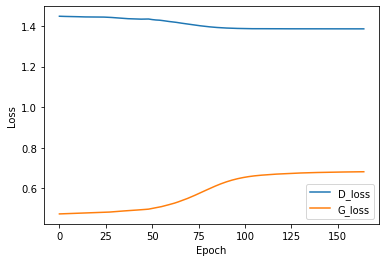

In [29]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

## For Bayesian
opt = {"lr": 0.00016, "epoch": 165, 'bs': 128}

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model()
gan = GAN(generator, discriminator, opt)
Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, opt)

In [30]:
# Rescale back the real dataset
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = index_train
test_predict_index = index_test

In [31]:
print("----- predicted price -----", Predicted_price)
rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

print("----- rescaled predicted price -----", rescaled_Predicted_price)
print("----- SHAPE rescaled predicted price -----", rescaled_Predicted_price.shape)

----- predicted price ----- [[-1.0202231]
 [-1.0216081]
 [-1.0151763]
 ...
 [-0.7606404]
 [-0.7598379]
 [-0.7483534]]
----- rescaled predicted price ----- [[  72.1458  ]
 [  26.953552]
 [ 236.82635 ]
 ...
 [8542.436   ]
 [8568.62    ]
 [8943.364   ]]
----- SHAPE rescaled predicted price ----- (1257, 1)


In [32]:
predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

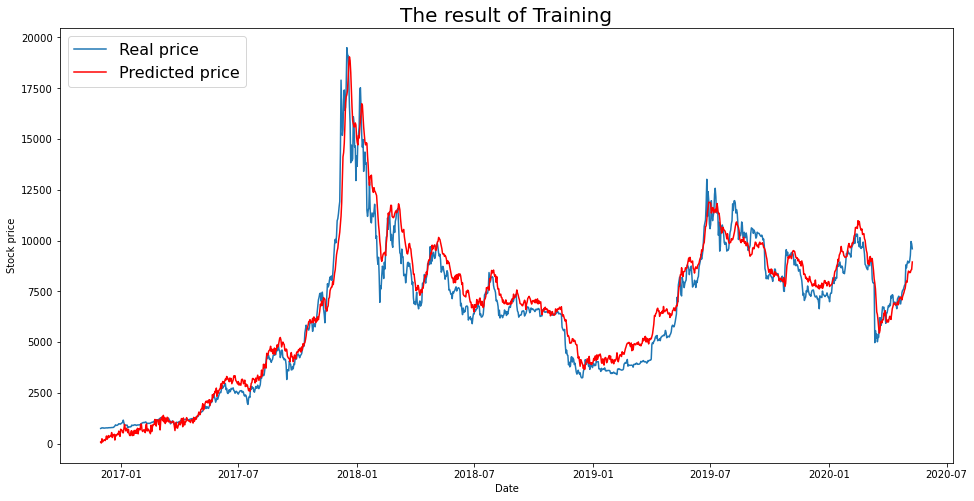

-- Train RMSE --  802.8348452506423


In [33]:
# Plot the predicted result
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of Training", fontsize=20)
plt.show()

# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- Train RMSE -- ', RMSE)

In [34]:
predicted

2016-11-30      72.145798
2016-12-01      26.953552
2016-12-02     236.826355
2016-12-03      82.274956
2016-12-04     159.142227
                 ...     
2020-05-05    8418.757812
2020-05-06    8426.807617
2020-05-07    8542.435547
2020-05-08    8568.620117
2020-05-09    8943.364258
Freq: D, Name: predicted_mean, Length: 1257, dtype: float32

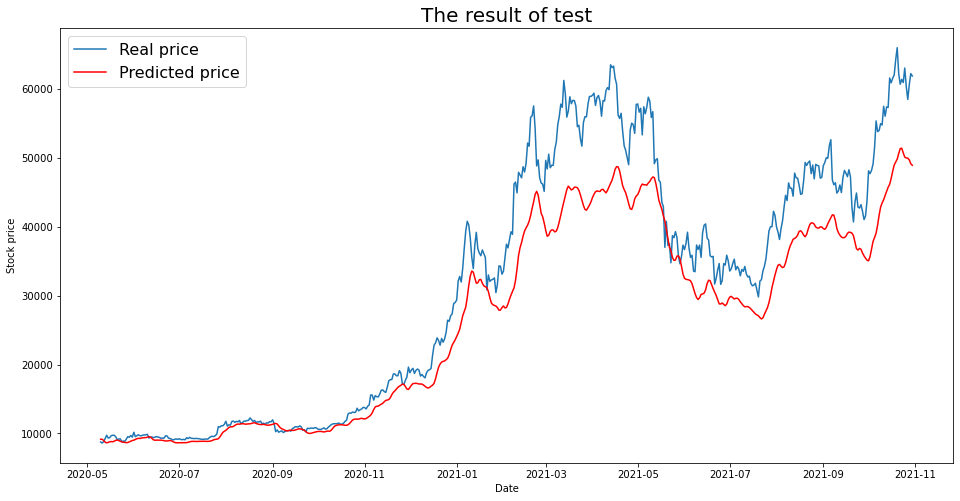

-- RMSE --  6896.990146518451


<Figure size 432x288 with 0 Axes>

In [35]:
# Load test dataset/ model
G_model = tf.keras.models.load_model('model_164.h5')

def get_test_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = G_model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    
    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of test", fontsize=20)
    plt.show()
    plt.savefig('test_plot.png')
    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- RMSE -- ', RMSE)

    return predict_result, RMSE,real_price


test_predicted, test_RMSE, test_real = get_test_plot(X_test, y_test)
test_predicted.to_csv("test_predicted.csv")


In [36]:
from sklearn.metrics import accuracy_score

In [37]:
test_predicted['predicted_mean'], test_real["real_mean"]

(2020-05-10     9147.975383
 2020-05-11     9152.571237
 2020-05-12     8954.027619
 2020-05-13     8723.097135
 2020-05-14     8630.979727
                   ...     
 2021-10-26    49983.284305
 2021-10-27    49955.748079
 2021-10-28    49699.780596
 2021-10-29    49143.380791
 2021-10-30    48919.803091
 Freq: D, Name: predicted_mean, Length: 539, dtype: float64,
 2020-05-10     8756.430664
 2020-05-11     8601.795898
 2020-05-12     8804.477539
 2020-05-13     9269.987305
 2020-05-14     9733.721680
                   ...     
 2021-10-26    60363.792970
 2021-10-27    58482.386720
 2021-10-28    60622.136720
 2021-10-29    62227.964840
 2021-10-30    61888.832030
 Freq: D, Name: real_mean, Length: 539, dtype: float64)

In [38]:
a=test_predicted['predicted_mean'].tolist()
a
b=test_real["real_mean"].tolist()
b

[8756.430664,
 8601.795897999998,
 8804.477539,
 9269.987305,
 9733.72168,
 9328.197265999997,
 9377.013672,
 9670.739258,
 9726.575195,
 9729.038086,
 9522.981445000001,
 9081.761719,
 9182.577148,
 9209.287108999999,
 8790.368164,
 8906.934569999998,
 8835.052734000003,
 9181.017578000003,
 9525.750976999998,
 9439.124023000002,
 9700.414063,
 9461.058594,
 10167.26856,
 9529.803711,
 9656.717773,
 9800.636719,
 9665.533202999999,
 9653.679688,
 9758.852538999998,
 9771.489257999998,
 9795.700194999998,
 9870.094727000002,
 9321.78125,
 9480.843750000002,
 9475.277344,
 9386.788086,
 9450.702148000002,
 9538.024414000001,
 9480.254883,
 9411.84082,
 9288.018555,
 9332.340820000001,
 9303.629883,
 9648.717773000002,
 9629.658203,
 9313.610352000002,
 9264.813477000002,
 9162.917969,
 9045.390625000002,
 9143.582030999998,
 9190.854492,
 9137.993164000001,
 9228.325195000001,
 9123.410156000002,
 9087.303711,
 9132.488281,
 9073.942383000001,
 9375.474609000003,
 9252.277344,
 9428.333

In [86]:
l_real=[]
l_predict=[]
for i in range(len(b)-1):
    if b[i+1]-b[i]<0:
        l_real.append(-1)
    elif (b[i+1]-b[i])/b[i]<0.001 and (b[i+1]-b[i])/b[i]>=0:
        l_real.append(0)
    elif (b[i+1]-b[i])/b[i]>0.001:
        l_real.append(1)
        
for i in range(len(b)-1):
    if a[i+1]-a[i]<0:
        l_predict.append(-1)
    elif (a[i+1]-a[i])/a[i]<0.001 and (a[i+1]-a[i])/a[i]>=0:
        l_predict.append(0)
    elif (a[i+1]-a[i])/a[i]>0.001:
        l_predict.append(1)

In [91]:
print(len(l_predict))
print(len(l_real))

538
538


In [88]:
real_11=0
real_0=0
real_1=0
for i in l_real:
    if i==1:
        real_1+=1
    elif i==-1:
        real_11+=1
    elif i==0:
        real_0+=1

p_real_11=real_11/len(l_real)*100
p_real_0=real_0/len(l_real)*100
p_real_1=real_1/len(l_real)*100
print(p_real_11, p_real_0, p_real_1)

44.42379182156134 1.6728624535315983 53.90334572490706


In [89]:
test_11=0
test_0=0
test_1=0
for i in l_predict:
    if i==1:
        test_1+=1
    elif i==-1:
        test_11+=1
    elif i==0:
        test_0+=1

p_test_11=test_11/len(l_predict)*100
p_test_0=test_0/len(l_predict)*100
p_test_1=test_1/len(l_predict)*100
print(p_test_11, p_test_0, p_test_1)

41.07806691449814 4.089219330855019 54.832713754646846


In [93]:
tr=0
for i in range(len(l_predict)):
    if l_predict[i]==l_real[i]:
        tr+=1
acc=tr/len(l_predict)
print(acc)

0.48698884758364314


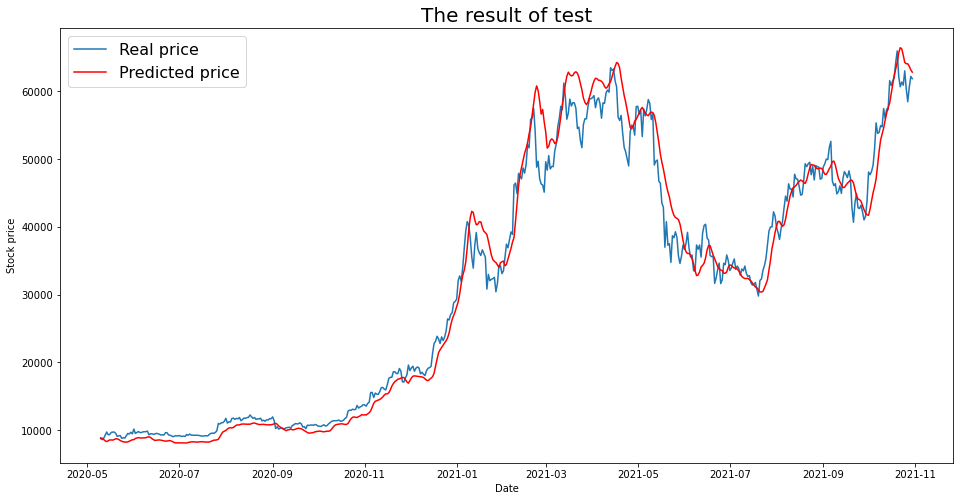

-- RMSE --  2889.9991560164285


<Figure size 432x288 with 0 Axes>

In [99]:
# Load test dataset/ model
G_model = tf.keras.models.load_model('LSTM_3to1.h5')

def get_test_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = G_model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    
    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of test", fontsize=20)
    plt.show()
    plt.savefig('test_plot.png')
    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- RMSE -- ', RMSE)

    return predict_result, RMSE,real_price


test_predicted, test_RMSE, test_real = get_test_plot(X_test, y_test)
test_predicted.to_csv("test_predicted.csv")
